In [4]:
# standard python imports
import numpy as np
import os
import scipy
import astropy.io.fits as pyfits
import scipy.ndimage
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# lenstronomy utility functions
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util

# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

In [5]:
# define data specifics
background_rms = .2  #  background noise per pixel
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 64  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
high_res_factor = 5
subgrid_res = high_res_factor  # we set the subgrid resolution to the high resolution image that we will show, so the same numerics will be applied.
fwhm = 0.1 # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'

# define lens model
lens_model_list = ['SPEP', 'SHEAR']
kwargs_spemd = {'theta_E': 0.5, 'gamma': 2., 'center_x':0, 'center_y': 0, 'e1': 0, 'e2': 0}
kwargs_shear = {'gamma1': 0.0, 'gamma2': 0.0}
kwargs_lens = [kwargs_spemd, kwargs_shear]

# define center of the source (effectively the center of the Shapelet basis)
source_x = 0.2
source_y = 0.

# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]

# for this example, we do not include deflector light
lens_light_model_list = ['NONE']
kwargs_lens_light = [{}]

from lenstronomy.LensModel.lens_model import LensModel
lensModel = LensModel(lens_model_list)

from lenstronomy.LightModel.light_model import LightModel
sourceLightModel = LightModel(source_model_list)

In [6]:
# here we perform the computation with the settings choosen above.
# We set up the different Data and PSF classes to perform and return the output at various stages of the computation
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar

shapeletSet = ShapeletSet()

# final data configuration
kwargs_data_real = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_real = ImageData(**kwargs_data_real)

# high resolution data configuration
kwargs_data_high_res = sim_util.data_configure_simple(numPix*high_res_factor, deltaPix/high_res_factor, exp_time, background_rms)
data_high_res = ImageData(**kwargs_data_high_res)

psf = PSF(psf_type=psf_type, fwhm=fwhm, truncation=5)
psf_high_res = psf
psf_no = PSF(psf_type='NONE')

# the numerics applied on the final data output to perform the identical computation as the high resolution gird
kwargs_numerics = {'supersampling_factor': subgrid_res, 'supersampling_convolution': True}

# and here we perform the computations
imageModel = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_no_noise_lensed = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

poisson = image_util.add_poisson(image_no_noise_lensed, exp_time=exp_time)
bkg = image_util.add_background(image_no_noise_lensed, sigma_bkd=background_rms)
image_real_lensed = image_no_noise_lensed + poisson + bkg

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_high_res, kwargs_numerics={}, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_high_res_conv_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_high_res_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel_ = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, source_model_class=sourceLightModel)
image_high_res_nolens_large = imageModel_.image(kwargs_lens=None, kwargs_source=kwargs_source, kwargs_lens_light=None, kwargs_ps=None)


/tmp/ipykernel_4090335/889034740.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color='k', alpha=1.)
/tmp/ipykernel_4090335/889034740.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_under('k')


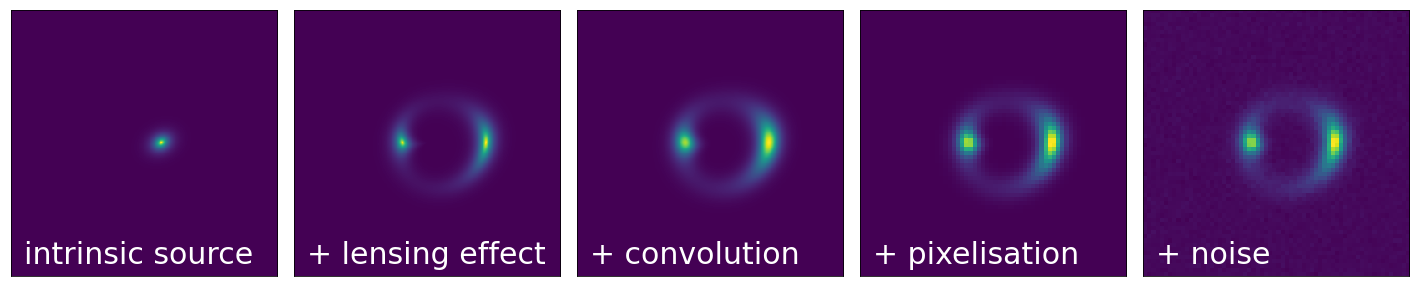

In [7]:
# the result is illustrated here

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = 0
v_max = 2

f, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False, sharey=False)


ax = axes[0]
im = ax.matshow((image_high_res_nolens_large), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
    
ax = axes[1]
im = ax.matshow((image_high_res_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
im = ax.matshow((image_high_res_conv_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
im = ax.matshow((image_no_noise_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[4]
im = ax.matshow((image_real_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)


i = 0
ax = axes[0]
x_pos, y_pos = 0.05, 0.05
fontsize_description = 30
ax.text(x_pos, y_pos, "intrinsic source", color="w", fontsize=fontsize_description)
ax = axes[1]
ax.text(x_pos, y_pos, "+ lensing effect", color="w", fontsize=fontsize_description)
ax = axes[2]
ax.text(x_pos, y_pos, "+ convolution", color="w", fontsize=fontsize_description)
ax = axes[3]
ax.text(x_pos, y_pos, "+ pixelisation", color="w", fontsize=fontsize_description)
ax = axes[4]
ax.text(x_pos, y_pos, "+ noise", color="w", fontsize=fontsize_description)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/Lenstronomy/LenstronomyPaper/simAPI.pdf', format='pdf')
plt.show()

In [16]:
from lenstronomy.LightModel.Profiles.shapelets_polar import ShapeletSetPolar

# update the data class with the realistc simulated image
data_real.update_data(image_real_lensed)
# initialize the ImageModel class

shapelet_type = 'polar' # 'cartesian', 'polar', 'exponential'


if shapelet_type == 'exponential':
    sourceLightModel_reconstruct = LightModel(['SHAPELETS_POLAR_EXP'])
    shapeletSet_reconstruct = ShapeletSetPolar(exponential=True)
    n_max_reconstruct = 7
    beta_reconstruct = 0.02
elif shapelet_type == 'polar':
    
    shapeletSet_reconstruct = ShapeletSetPolar(exponential=False)
    sourceLightModel_reconstruct = LightModel(['SHAPELETS_POLAR'])
    n_max_reconstruct = 20
    beta_reconstruct = 0.15
else:
    sourceLightModel_reconstruct = LightModel(['SHAPELETS'])
    shapeletSet_reconstruct = shapeletSet
    n_max_reconstruct = 20
    beta_reconstruct = 0.15

from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
imageModel = ImageLinearFit(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel_reconstruct)

kwargs_lens = [kwargs_spemd, kwargs_shear]  # we use the same lens model to reconstruct the image

kwargs_source = [{'n_max': n_max_reconstruct, 'center_x': source_x, 'center_y': source_y, 'beta': beta_reconstruct}]

# this is the linear inversion
wls_model, _, cov_param, param = imageModel.image_linear_solve(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None, inv_bool=False)
lensed_reconstructed = wls_model

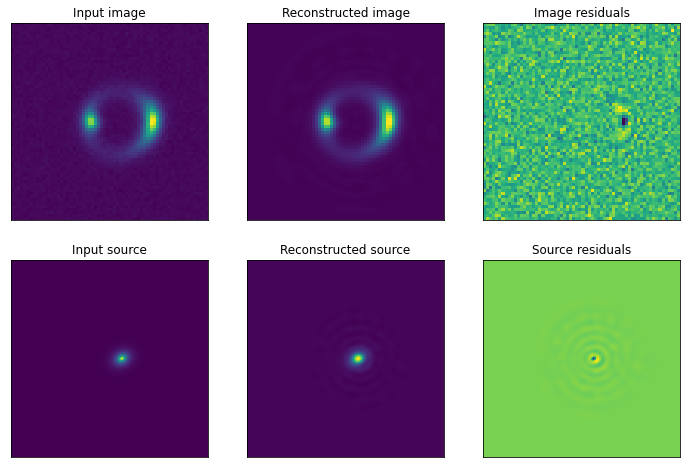

In [17]:
# given the solution of the linear inversion, we can also plot the coefficients in the source plane

x_coords, y_coords = data_high_res.pixel_coordinates
source_reconstructed = shapeletSet_reconstruct.function(util.image2array(x_coords), util.image2array(y_coords), param, n_max_reconstruct, beta_reconstruct, center_x=source_x, center_y=source_y)
source_reconstructed_2d = util.array2image(source_reconstructed) * (deltaPix/high_res_factor)**2  # map 1d data vector in 2d image


f, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=False)
ax = axes[0,0]
ax.matshow(image_real_lensed, origin='lower')
ax.set_title("Input image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[0,1]
ax.matshow(wls_model, origin='lower')
ax.set_title("Reconstructed image")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
# and here the reduced residuals

ax = axes[0,2]
reduced_residuals = imageModel.reduced_residuals(wls_model)
ax.matshow(reduced_residuals, origin='lower')
ax.set_title("Image residuals")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1,0]
ax.matshow(image_high_res_nolens_large, origin='lower')
ax.set_title("Input source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[1,1]
ax.matshow(source_reconstructed_2d, origin='lower')
ax.set_title("Reconstructed source")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

# and here the residuals relative to the true input source
ax = axes[1,2]
ax.matshow(source_reconstructed_2d - image_high_res_nolens_large, origin='lower')
ax.set_title("Source residuals")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/Lenstronomy/LenstronomyPaper/de_lens_shapelets.pdf', format='pdf')


plt.show()

